In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import septum_mec.analysis.data_processing as dp
from septum_mec.analysis.plotting import plot_psth, plot_waveforms
import expipe
import os
import pathlib
import numpy as np
import exdir
from scipy.interpolate import interp1d
import pandas as pd
import optogenetics as og
import quantities as pq

09:03:24 [I] klustakwik KlustaKwik2 version 0.2.6


In [12]:
par = {'speed_filter': 5, # m/s
    'pos_fs': 100 ,
    'f_cut': 6 ,
    'spat_binsize': 0.02 ,
    'grid_stepsize': 0.1 ,
    'box_xlen': 1 ,
    'box_ylen': 1 ,
    'spike_size': 10,
    'field_max_wall_extent':0.1,
    'field_min_bins':12
}

binsize = par['spat_binsize']
smoothing = 0.03
plt.rcParams['figure.figsize'] = (12,9)

In [4]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [5]:
def psth(sptr, stim_times, start_time, stop_time, binsize, axs=None):
    if not axs:
        fig, axs = plt.subplots(2, 1, sharex=True)
    
    spike_times = sptr.magnitude
    trials = [spike_times[(spike_times > t + start_time) & (spike_times <= t + stop_time)] - t for t in stim_times]
    trials_ids = [[i]*len(t) for i, t in enumerate(trials)]

    trials_flat = [s for t in trials for s in t]
    trials_ids_flat = [s for t in trials_ids for s in t]

    axs[1].scatter(trials_flat, trials_ids_flat, s=1)
    bins = np.arange(start_time, stop_time + binsize, binsize)
    axs[0].hist(trials_flat, bins=bins);
    axs[0].set_title('channel group {} {}'.format(
        sptr.annotations['group_id'], sptr.annotations['name']))

In [6]:
action_id = "1833-050619-2"
channel_ids = range(8)
t_start = 0
t_stop = None

action  = actions[action_id]

data_path = dp.get_data_path(action)
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])

epochs = dp.load_epochs(data_path)

Project path: /media/storage/expipe/septum-mec
Data path: actions/1833-050619-2/data/main.exdir


In [7]:
print('stimulation periode', np.diff(epochs[0].times.magnitude).mean())
print('stimulation frequency', 1 / np.diff(epochs[0].times.magnitude).mean())

stimulation periode 0.09000341034103411
stimulation frequency 11.110690097307154


No spikes in channel group 0


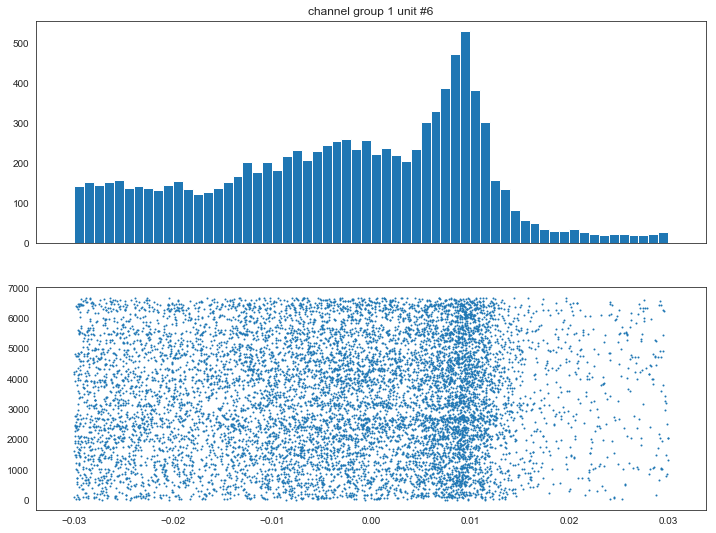

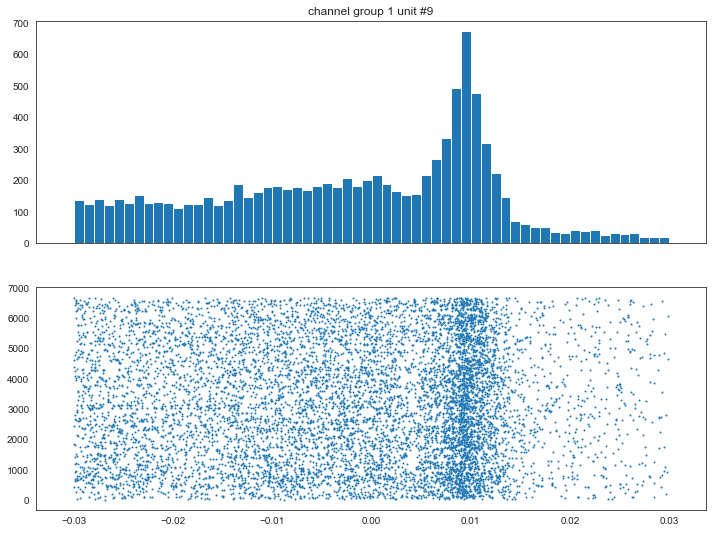

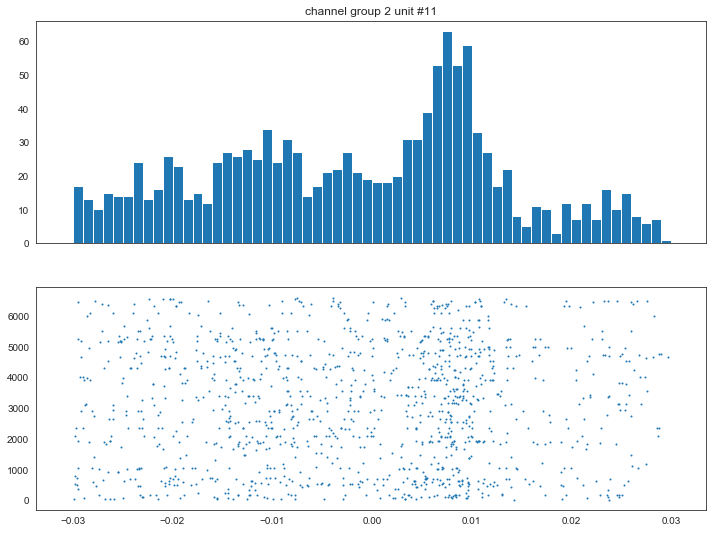

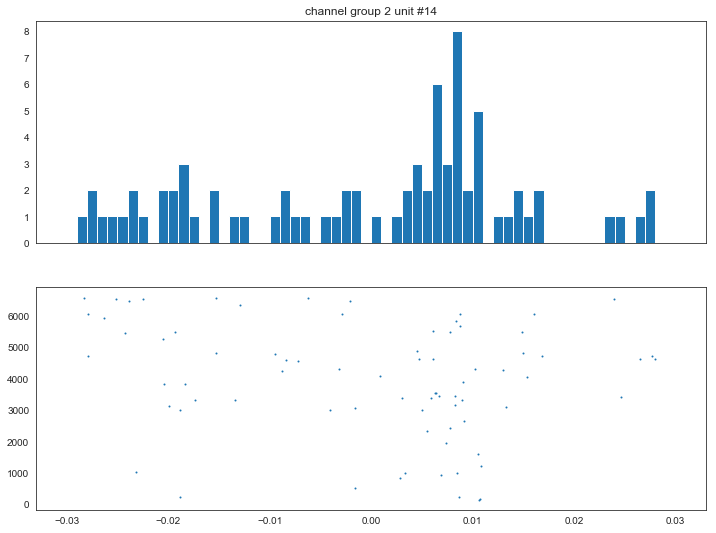

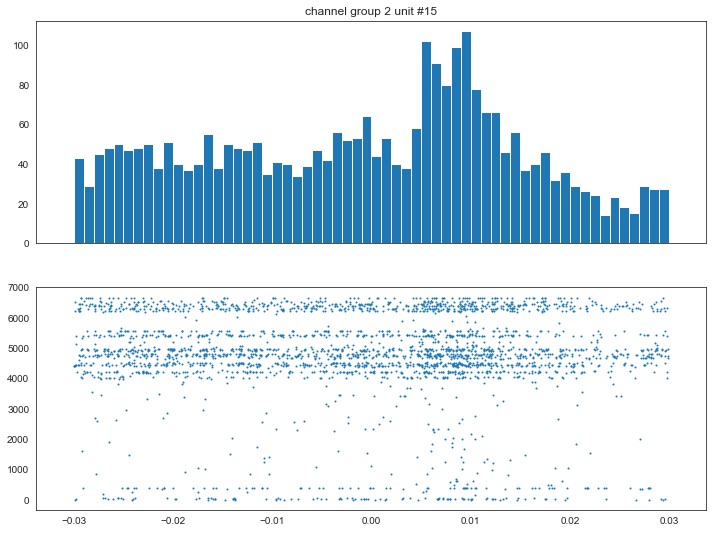

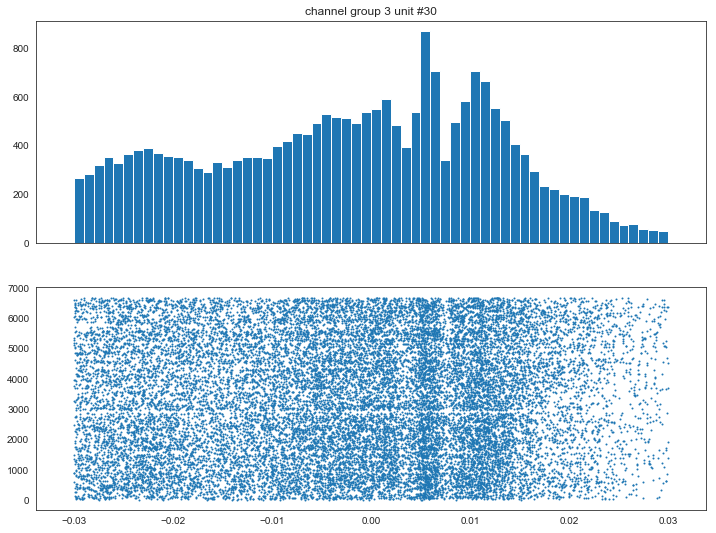

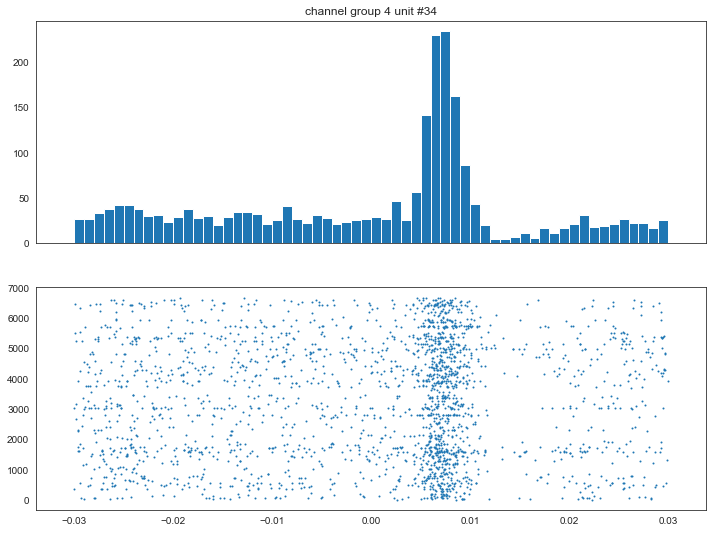

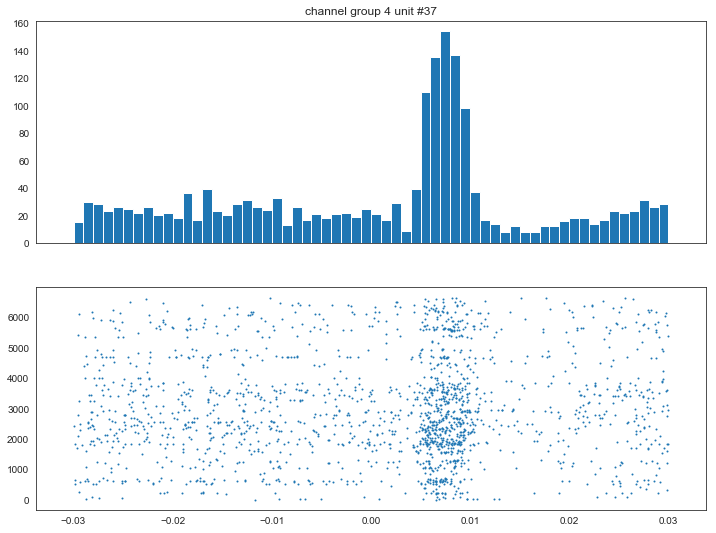

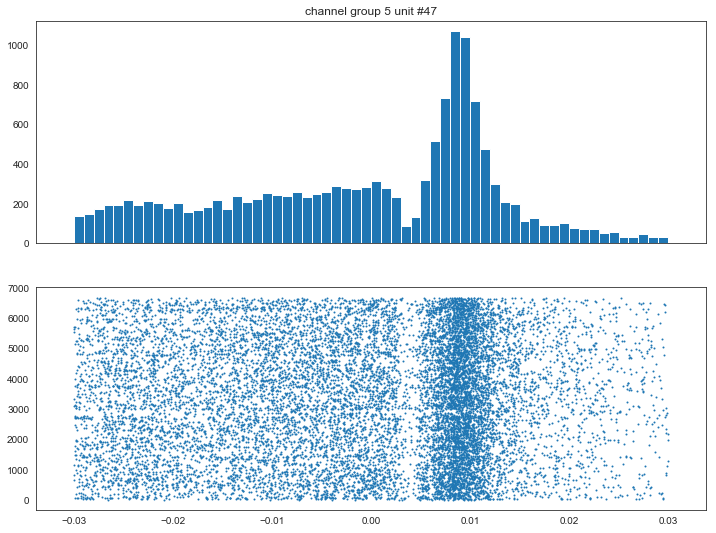

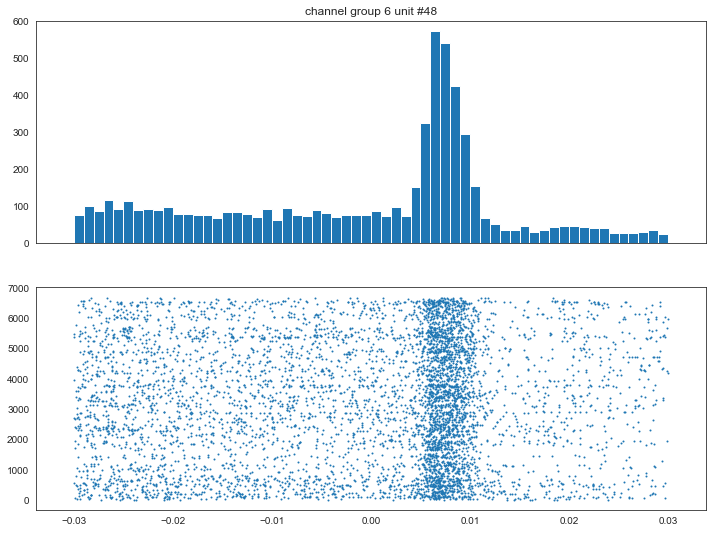

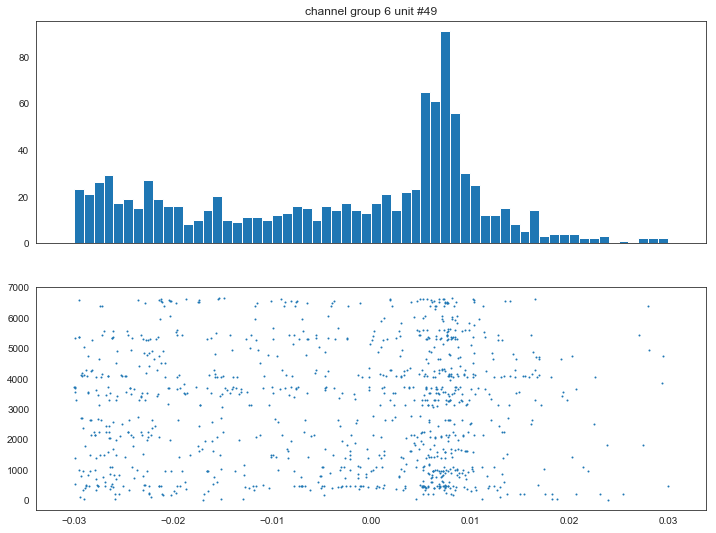

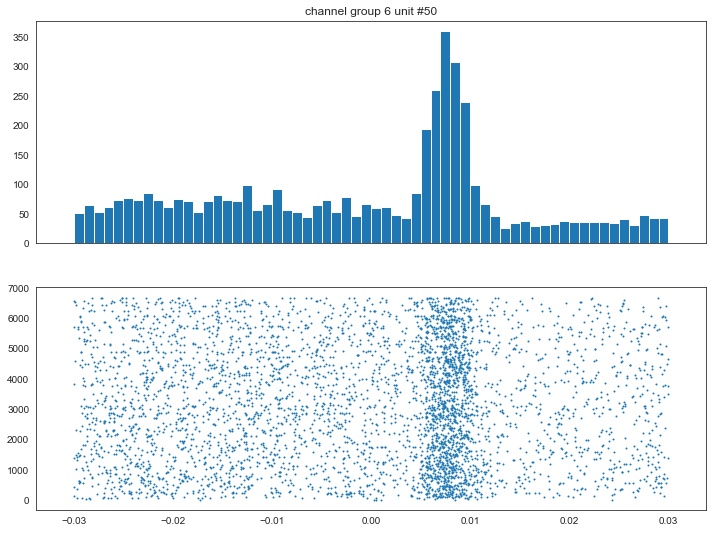

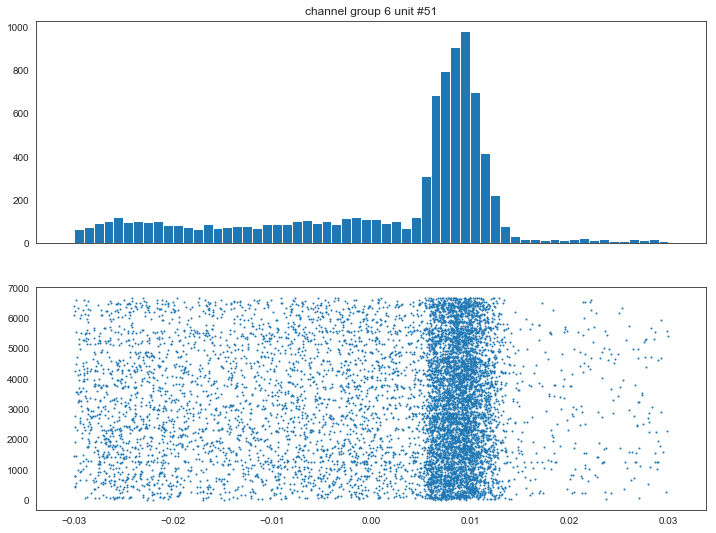

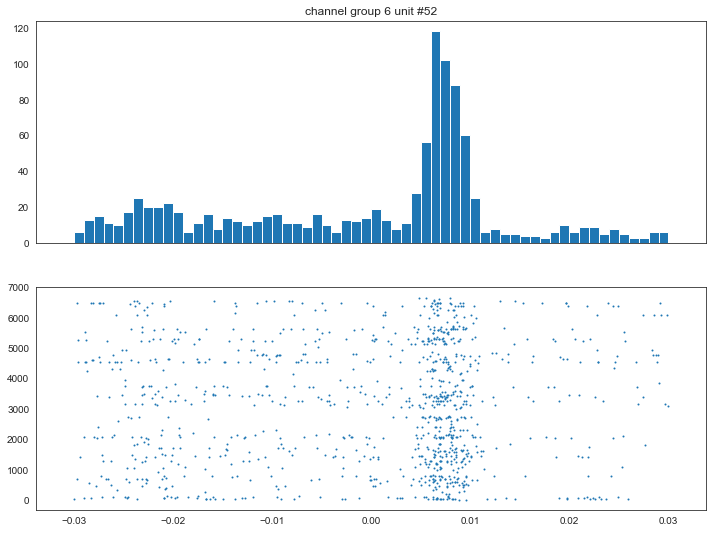

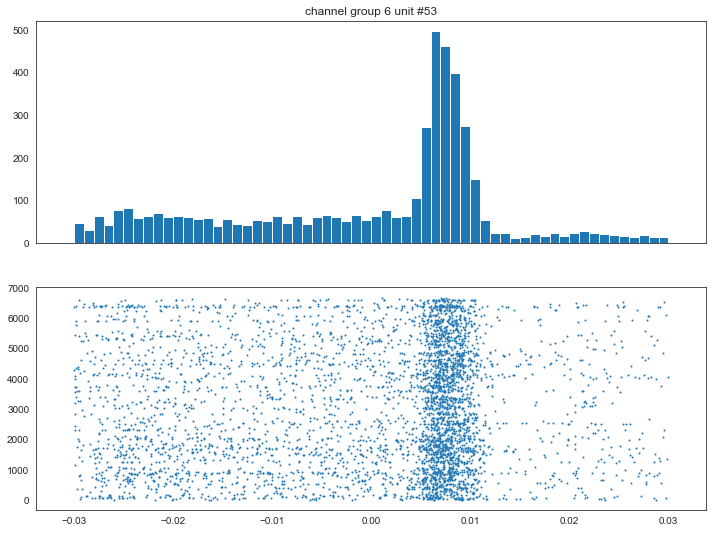

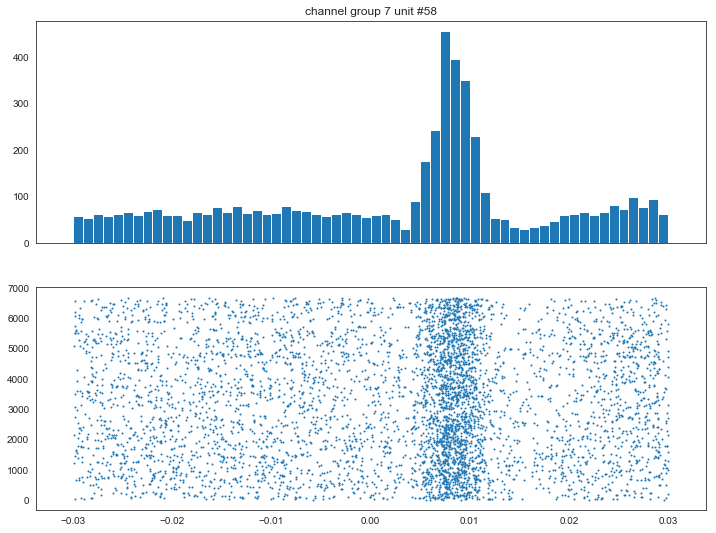

In [14]:
if t_start is not None and t_stop is not None:
    mask = (t < t_stop) & (t > t_start)
    x, y, t = x[mask], y[mask], t[mask]

for channel_id in channel_ids:
    spike_trains = dp.load_spiketrains(data_path, channel_id, load_waveforms=True)
    if len(spike_trains) == 0:
        print('No spikes in channel group {}'.format(channel_id))
        continue
            
    spike_trains = dp.sort_by_cluster_id(spike_trains)
    for spike_times in spike_trains:
        if t_start is not None and t_stop is not None:
            spike_mask = (spike_times < t_stop) & (spike_times > t_start)
            spike_times = spike_times[spike_mask]

        psth(spike_times, epochs[0].times.magnitude, -0.03, 0.03, 0.001)
